In [ ]:
!pip install yfinance   ## installing yfinance python package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, Dense, LSTM, GRU
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ReLU, Dropout, LayerNormalization


import torch
import torch.nn as nn
import torch.nn.functional as f

# Utility functions


In [3]:
## function to fetch the data as per the start date and column(open, close, volume etc)
## returns the data as a numpy array
def fetchdata(scrip, start = '2015-10-01', column = 'Close'):
  data = yf.download(scrip, start = start)
  data = data.reset_index()[column]
  print(data)
  return np.array(data)

In [4]:
## function to convert the data into range [0,1] as the values will vary over a large range and values ranges will be different for different stocks
def process(data):
  data = np.reshape(data, (data.shape[0],1))
  scaler = MinMaxScaler(feature_range=(0,1))
  df = scaler.fit_transform(data)
  return df, scaler   ## returning scaler as well because it will be usefull while converting the values back again

In [5]:
## function to convert the scaled values into normal values for plotting
def revconvert(data, scaler):
  return scaler.inverse_transform(data)

In [6]:
## converts the data into stepped data which will be useful while training various networks
def convert(data, steps):
  x, y = [],[]
  for start in range(0,len(data)):
    end = start + steps
    if end > len(data)-1:
      break
    xl, yl = data[start : end], data[end]
    x.append(xl)
    y.append(yl)
  return np.array(x), np.array(y)

# Functions for plotting and summaries

In [7]:
def summary(models):
  for model in models:
    model.summary()

In [8]:
def pltmodel(models):
  for model in models:
    tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False, to_file = f"{model}.png")

# Functions to compare the results of models

In [9]:
def comparemodels(models, modelnames, stockscrips, steps):
  for stock in stockscrips:
    data = fetchdata(stock)
    data, scaler = process(data)
    xtrain, ytrain = convert(data, steps)
    print(f"****************** For {stock} ********************")
    i = 0
    for model in models:
      pred = model.predict(xtrain)
      loss = np.sum(np.square(pred - ytrain))
      print(f"Model {modelnames[i]} - Loss {loss}")
      i += 1

In [10]:
def forecast(models, modelnames, scrips, steps, days = 10):
  preds = dict()
  for scrip in scrips:
    dic = dict()
    data = fetchdata(scrip, start = '2019-01-01')   ## most recent data suffices as we'd be using only last steps no of dates for prediction
    data, scaler = process(data)
    xtrain, ytrain = convert(data, steps)
    start = ytrain.shape[0] - steps
    for model in modelnames:
      a = np.zeros((steps + days,1))
      a[0:steps] = ytrain[start:]
      dic[model] = a
    for i in range(0, days):
      for j in range(0, len(models)):
        a = dic[modelnames[j]][i:i+steps]
        a = np.reshape(a,(1, a.shape[0], a.shape[1]))
        pred = models[j].predict(a)
        dic[modelnames[j]][i+steps] = pred[0,0]
    for model in modelnames:
      dic[model] = scaler.inverse_transform(dic[model][steps:])
      #dic[model] = dic[model][steps:]
    preds[scrip] = dic
  return preds


In [11]:
def plotresultsforstocks(models, modelnames, stockscrips, steps):
  for stock in stockscrips:
    data = fetchdata(stock)
    data, scaler = process(data)
    xtrain, ytrain = convert(data, steps)
    print(f"****************** For {stock} ********************")
    i = 0
    for model in models:
      pred = model.predict(xtrain)
      plt.plot(scaler.inverse_transform(ytrain))
      plt.plot(scaler.inverse_transform(pred))
      plt.title(f"Model {modelnames[i]}")
      plt.show()
      i += 1

In [12]:
def plotresults(models, xtrain, ytrain, scaler, modelnames):
  i = 0
  for model in models:
    pred = model.predict(xtrain)
    plt.plot(scaler.inverse_transform(ytrain))
    plt.plot(scaler.inverse_transform(pred))
    plt.title(f"Model {modelnames[i]}")
    plt.show()
    i += 1

In [13]:
def plotforecast(modelnames, scrips, preds):    ## should change this by taking inverse transform etc ##
  for scrip in scrips:
    for model in modelnames:
      plt.plot(preds[scrip][model], label = model)
    plt.title(f"Forecast for {scrip}")
    plt.show()

# Functions to return models

In [14]:
def cnnmodel(steps):
    model = Sequential([
      Conv1D(filters = 32, kernel_size=8, activation = 'relu', input_shape=(steps, 1)),
      MaxPooling1D(pool_size=2),
      Conv1D(filters = 16, kernel_size = 4, activation = 'relu'),
      MaxPooling1D(pool_size=2),
      Flatten(),
      Dense(16, activation='relu'),
      Dense(1),
    ])
    return model

In [15]:
def lstmmodel(steps):
  model=Sequential([
    LSTM(int(steps/2),return_sequences=True,input_shape=(steps,1)),
    LSTM(int(steps/6),return_sequences=True),
    LSTM(int(steps/16),return_sequences=True),
    LSTM(8),
    Dense(1),
  ])
  return model

In [16]:
def grumodel(steps):
  model=Sequential([
    GRU(int(steps/2),return_sequences=True,input_shape=(steps,1)),
    GRU(int(steps/6),return_sequences=True),
    GRU(int(steps/16),return_sequences=True),
    GRU(8),
    Dense(1),
  ])
  return model

# Training the models

In [17]:
def train(models, xtrain, ytrain, epochs = 100, batchsize = 32):
  for model in models:
    print(f"************ Training for model {model} *************")
    model.compile(optimizer='adam', loss='mse')
    model.fit(xtrain, ytrain, epochs = epochs, batch_size = batchsize)

# Main code


In [18]:
data = fetchdata('BTC-USD')

[*********************100%***********************]  1 of 1 completed
0         237.548996
1         237.292999
2         238.729996
3         238.259003
4         240.382996
            ...     
2607    16291.832031
2608    15787.284180
2609    16189.769531
2610    16610.707031
2611    16560.283203
Name: Close, Length: 2612, dtype: float64


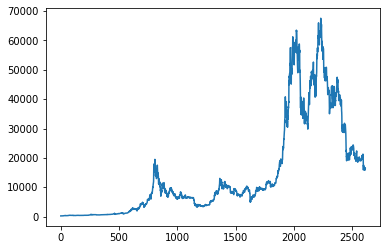

In [19]:
plt.plot(data)

In [21]:
steps = 200   ## hyperparameter to be tuned

In [22]:
databtc, scalerbtc = process(data)
xtrain, ytrain = convert(databtc, steps)

In [23]:
cnn = cnnmodel(steps)
lstm = lstmmodel(steps)
gru = grumodel(steps)

models = [cnn, lstm, gru]

In [24]:
modelnames = ['cnn', 'lstm', 'gru']

In [ ]:
summary(models)

In [26]:
train(models, xtrain, ytrain, 100, 32)

************ Training for model <keras.engine.sequential.Sequential object at 0x7f14180118d0> *************
Epoch 1/100
76/76 [==============================] - 8s 5ms/step - loss: 0.0156
Epoch 2/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 3/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 4/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 5/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 6/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 7/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 8/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 9/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 10/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 11/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 12/1

76/76 [==============================] - 0s 2ms/step


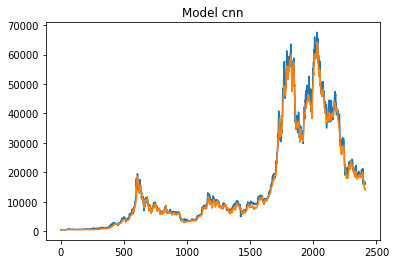

76/76 [==============================] - 2s 12ms/step


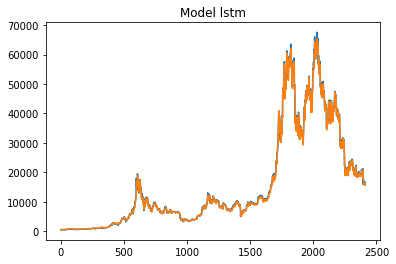

76/76 [==============================] - 2s 9ms/step


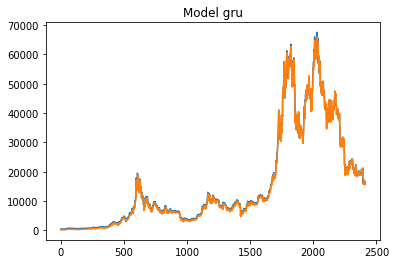

In [27]:
plotresults(models, xtrain, ytrain, scalerbtc, modelnames)

In [28]:
scrips = ['AAPL', 'GOOGL', 'TSLA']
comparemodels(models, modelnames, scrips, steps)

[*********************100%***********************]  1 of 1 completed
0        27.395000
1        27.594999
2        27.695000
3        27.827499
4        27.695000
           ...    
1796    150.720001
1797    151.289993
1798    148.009995
1799    150.179993
1800    151.070007
Name: Close, Length: 1801, dtype: float64
****************** For AAPL ********************
51/51 [==============================] - 0s 2ms/step
Model cnn - Loss 10.026978694894884
51/51 [==============================] - 1s 12ms/step
Model lstm - Loss 0.33117646750119556
51/51 [==============================] - 0s 9ms/step
Model gru - Loss 0.2969301540699957
[*********************100%***********************]  1 of 1 completed
0       32.099998
1       32.849499
2       33.584000
3       33.582001
4       33.500000
          ...    
1796    98.360001
1797    97.430000
1798    95.599998
1799    97.050003
1800    98.459999
Name: Close, Length: 1801, dtype: float64
****************** For GOOGL ********************
51

[*********************100%***********************]  1 of 1 completed
0        27.395000
1        27.594999
2        27.695000
3        27.827499
4        27.695000
           ...    
1796    150.720001
1797    151.289993
1798    148.009995
1799    150.179993
1800    151.070007
Name: Close, Length: 1801, dtype: float64
****************** For AAPL ********************
51/51 [==============================] - 0s 2ms/step


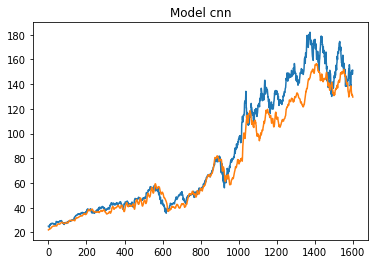

51/51 [==============================] - 1s 13ms/step


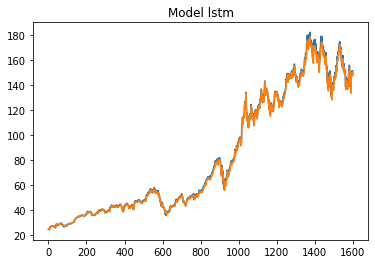

51/51 [==============================] - 0s 10ms/step


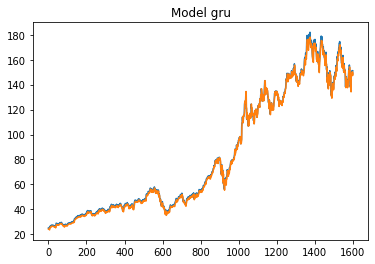

[*********************100%***********************]  1 of 1 completed
0       32.099998
1       32.849499
2       33.584000
3       33.582001
4       33.500000
          ...    
1796    98.360001
1797    97.430000
1798    95.599998
1799    97.050003
1800    98.459999
Name: Close, Length: 1801, dtype: float64
****************** For GOOGL ********************
51/51 [==============================] - 0s 2ms/step


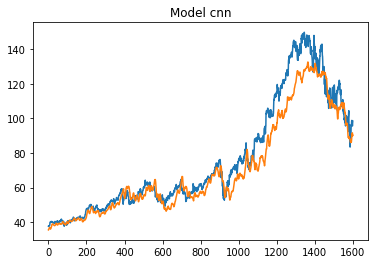

51/51 [==============================] - 1s 10ms/step


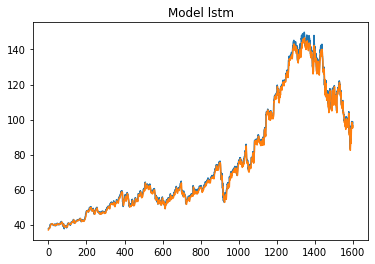

51/51 [==============================] - 0s 10ms/step


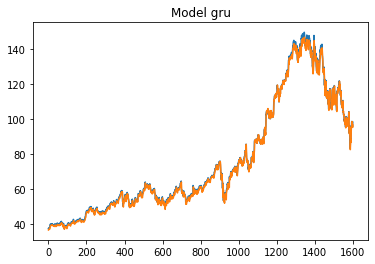

[*********************100%***********************]  1 of 1 completed
0        15.992000
1        16.504667
2        16.410000
3        16.097334
4        15.464000
           ...    
1796    183.169998
1797    180.190002
1798    167.869995
1799    169.910004
1800    183.199997
Name: Close, Length: 1801, dtype: float64
****************** For TSLA ********************
51/51 [==============================] - 0s 2ms/step


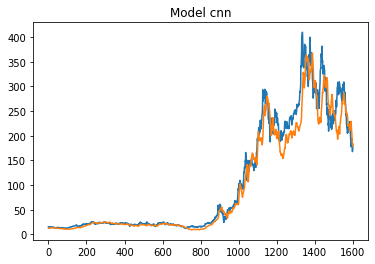

51/51 [==============================] - 1s 10ms/step


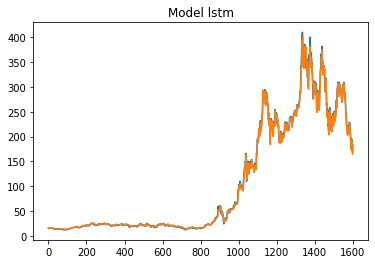

51/51 [==============================] - 1s 10ms/step


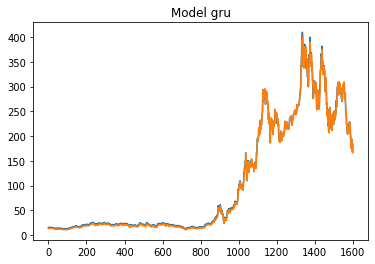

In [29]:
plotresultsforstocks(models, modelnames, scrips, steps)

In [30]:
preds = forecast(models, modelnames, scrips, steps)

[*********************100%***********************]  1 of 1 completed
0       39.480000
1       35.547501
2       37.064999
3       36.982498
4       37.687500
          ...    
978    150.720001
979    151.289993
980    148.009995
981    150.179993
982    151.070007
Name: Close, Length: 983, dtype: float64
1/1 [==============================] - 0s 22ms/step
[*********************100%***********************]  1 of 1 completed
0      52.734001
1      51.273499
2      53.903500
3      53.796001
4      54.268501
         ...    
978    98.360001
979    97.430000
980    95.599998
981    97.050003
982    98.459999
Name: Close, Length: 983, dtype: float64
1/1 [==============================] - 0s 21ms/step
[*********************100%***********************]  1 of 1 completed
0       20.674667
1       20.024000
2       21.179333
3       22.330667
4       22.356667
          ...    
978    183.169998
979    180.190002
980    167.869995
981    169.910004
982    183.199997
Name: Close, Length: 983

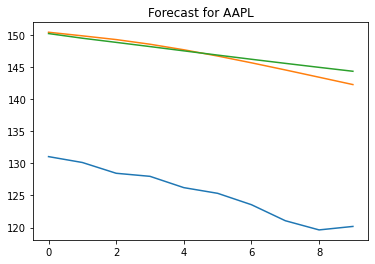

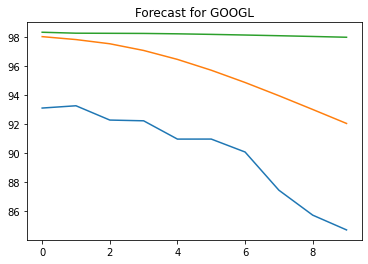

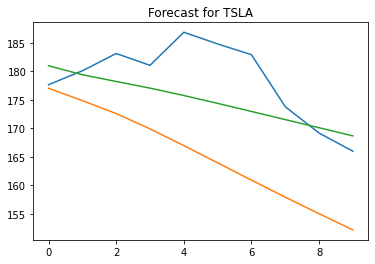

In [31]:
plotforecast(modelnames, scrips, preds)

# Helper functions for transformers

In [32]:
'''
Various indicators
'''
def daily_return(df: pd.DataFrame):
    df['Daily_returns'] = df['Close'].pct_change(1).fillna(0)
    return df

### MOMENTUM INDICATORS ###
def roc_indicator(df: pd.DataFrame):
    # Computes rate of change (RoC), i.e momentum - percent change
    df["RoC"] = df['Close'].diff() / df['Close'][:-1]
    return df

def williams_r(df: pd.DataFrame, lookback: int):
    # Computes Williams %R that measures overbought and oversold levels
    wr = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            wr[t_idx] = 0
        else:
            highest = np.max(df['High'][t_idx-lookback:t_idx].values)
            lowest = np.min(df['Low'][t_idx-lookback:t_idx].values)
            wr[t_idx] = (highest - df['Close'][t_idx]) / (highest - lowest)
    df["williams_r"] = wr
    return df

### VOLUME INDICATORS ###
def money_flow_index(df: pd.DataFrame, period: int):
    # Measures buying and selling pressure (if below 20 then buy if above 80 then sell)
    typical_price = (df['Close'] + df['High'] + df['Low']) / 3
    money_flow = typical_price * df['Volume']
    positive_flow, negative_flow = [], []
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i-1])
            negative_flow.append(0)
        elif typical_price[i] < typical_price[i-1]:
            positive_flow.append(0)
            negative_flow.append(money_flow[i-1])
        else:
            positive_flow.append(0)
            negative_flow.append(0)

    positive_mf = [sum(positive_flow[i + 1 - period:i + 1]) for i in range(period-1, len(positive_flow))]
    negative_mf = [sum(negative_flow[i + 1 - period:i + 1]) for i in range(period - 1, len(negative_flow))]
    idx = 0
    mfi = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= period:
            mfi[t_idx] = 0
        else:
            mfi[t_idx] = 100 * (positive_mf[idx] / (positive_mf[idx] + negative_mf[idx]))
            idx += 1
    df["MFI"] = mfi
    return df

### VOLATILITY INDICATORS ###
def ulcer_index(df: pd.DataFrame, lookback: int):
    # Measures downside risk in terms of depth and duration of price declines
    ui = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            ui[t_idx] = 0
        else:
            maxprice = np.max(df['Close'][t_idx-lookback:t_idx].values)
            percentage_drawdown = [(df['Close'][t_idx-i]-maxprice)/maxprice * 100 for i in reversed(range(lookback))]
            ulcer_ind = np.sqrt(np.sum(np.array(percentage_drawdown)**2) / lookback)
            ui[t_idx] = ulcer_ind
    df['Ulcer_index'] = ui
    return df

def average_true_range(df: pd.DataFrame, lookback: int):
    # Measures market volatility
    av_tr_rang = np.zeros(len(df))
    for t_idx in range(len(df)):
        if t_idx + 1 <= lookback:
            av_tr_rang[t_idx] = 0
        else:
            true_ranges = []
            for idx in reversed(range(lookback)):
                tr1 = df['High'][t_idx-idx] - df['Low'][t_idx-idx]
                tr2 = np.abs(df['High'][t_idx-idx] - df['Close'][t_idx-idx])
                tr3 = np.abs(df['Low'][t_idx-idx] - df['Close'][t_idx-idx])
                true_ranges.append(np.max([tr1, tr2, tr3]))
            atr = sum(true_ranges) / lookback
            av_tr_rang[t_idx] = atr
    df['ATR'] = av_tr_rang
    return df

### TREND INDICATORS ###

def simple_moving_average(df: pd.DataFrame, windows: list):
    for window in windows:
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean().fillna(0)
    return df

def exponential_moving_average(df: pd.DataFrame, windows: list):
    for window in windows:
        df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean().fillna(0)
    return df


def get_indicators(df: pd.DataFrame):
    df = daily_return(df)
    df = roc_indicator(df)
    df = williams_r(df, 14)
    df = money_flow_index(df, 14)
    df = ulcer_index(df, 14)
    df = average_true_range(df, 14)
    df = simple_moving_average(df, [5, 10, 20])
    df = exponential_moving_average(df, [20, 50])
    return df

def preprocess_data(df):
    if df.columns[0] == 'Date':
        df = df.set_index('Date')

    df = get_indicators(df)
    return df


In [33]:
def get_stationary_data(df:pd.DataFrame, columns:list, diff:int):
    # Making the data stationary
    df_cp = df.copy()
    for col in columns:
        df_cp[str(col)] = pd.DataFrame(np.log(df_cp[str(col)]).diff().diff(diff))
    return df_cp

def inverse_stationary_data(old_df:pd.DataFrame, new_df: pd.DataFrame, orig_feature: str,
                            new_feature: str, diff: int, do_orig=True):
    # Inverse the stationary data transformation

    if do_orig:
        new_df[orig_feature] += np.log(old_df[orig_feature]).shift(1)
        new_df[orig_feature] += np.log(old_df[orig_feature]).diff().shift(diff)
        new_df[orig_feature] = np.exp(new_df[orig_feature])
    new_df[new_feature] += np.log(old_df[orig_feature]).shift(1)
    new_df[new_feature] += np.log(old_df[orig_feature]).diff().shift(diff)
    new_df[new_feature] = np.exp(new_df[new_feature])
    return new_df

In [34]:
class GetDataset(object):
    def __init__(self, df):
        super(GetDataset, self).__init__()
        self.df = df
        self.df["Next_day_closing_price"] = df["Close"].shift(-1).dropna()
        if self.df.columns[0] == 'Date':
            self.df = self.df.set_index('Date')
        self.df["Actual"] = self.df["Next_day_closing_price"]



    def get_dataset(self, scale=True, stationary=True, indicators=False):
        '''
            Input: scale - if to scale the input data
        '''
        x_df = self.df[["Close", "Open", "High", "Low", "Volume"]].dropna()[:-1]
        y_df = self.df["Next_day_closing_price"].dropna().fillna(0)

        x_processed_df = preprocess_data(x_df).fillna(0)
        if stationary:
            for col in x_processed_df.columns:
                x_processed_df = get_stationary_data(x_processed_df, [col], 12)

            y_df = get_stationary_data(self.df, ["Next_day_closing_price"], 12)['Next_day_closing_price']
            y_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        x_processed_df.replace([np.inf, -np.inf], 0, inplace=True)


        self.x_data_values = x_processed_df.fillna(0).values[:-1]
        self.y_data_values = y_df.values[:-1].reshape(-1, 1)

        self.x_scaler = MinMaxScaler(feature_range=(-1, 1))
        self.y_scaler = MinMaxScaler(feature_range=(-1, 1))

        if scale:
            self.x_data = self.x_scaler.fit_transform(self.x_data_values)
            self.y_data = self.y_scaler.fit_transform(self.y_data_values)
        else:
            self.x_data = self.x_data_values
            self.y_data = self.y_data_values


    def get_size(self):
        '''
            Output: returns the length of the dataset
        '''
        return len(self.x_data)


    def split(self, train_split_ratio=0.8, time_period=30):
        '''
            Input: train_split_ratio - percentage of dataset to be used for
                                       the training data (float)
                   time_period - time span in days to be predicted (in)

            Output: lists of the training and validation data (input values and target values)
                    size of the training data
        '''

        train_data_size = int(np.ceil(self.get_size() * train_split_ratio))
        x_train_data = self.x_data[:train_data_size]
        y_train_data = self.y_data[:train_data_size]

        x_train = [x_train_data[i-time_period:i] for i in range(time_period, len(x_train_data))]
        y_train = y_train_data[time_period:]


        self.y_train = np.array(y_train)
        self.x_train = np.array(x_train)
        print(f'Shape of train data: (x, y) = ({np.shape(self.x_train)}, {np.shape(self.y_train)})')

        x_test_data = self.x_data[train_data_size - time_period:]
        y_test = self.y_data[train_data_size:]
        x_test = [x_test_data[i-time_period:i] for i in range(time_period, len(x_test_data))]

        self.y_test = np.array(y_test)
        self.x_test = np.array(x_test)
        print(f'Shape of test data: (x, y) = ({np.shape(self.x_test)}, {np.shape(self.y_test)})')
        return [self.x_train, self.y_train], [self.x_test, self.y_test], train_data_size


    def get_torchdata(self):
        self.x_train_tensor = torch.from_numpy(self.x_train).type(torch.Tensor)
        self.x_test_tensor = torch.from_numpy(self.x_test).type(torch.Tensor)

        self.y_train_tensor = torch.from_numpy(self.y_train).type(torch.Tensor)
        self.y_test_tensor = torch.from_numpy(self.y_test).type(torch.Tensor)

        return [self.x_train_tensor, self.y_train_tensor], [self.x_test_tensor, self.y_test_tensor]


# Implementation of a transformer model

In [35]:
def scaled_dot_product_attention(query, key, value):
    '''
    Computes the local fields and the attention of the inputs as described in Vaswani et. al.
    and then scale it for a total sum of 1

    INPUT: query, key, value - input data of size (batch_size, seq_length, num_features)
    '''

    temp = query.bmm(key.transpose(1, 2))
    scale = query.size(-1) ** 0.5
    softmax = f.softmax(temp / scale, dim=-1)
    attention = softmax.bmm(value)
    return attention


class MultiHeadAttention(nn.Module):
    '''
    Computes the multihead head consisting of a feedforward layer for each input value
    where the attention for all of these are computed for each head and then concatenated and projected
    as described in Vaswani et. al.

    INPUT: dimensions of the three matrices (where the key and query matrix has the same dimensions) and the nr of heads
    OUTPUT: the projected output of the multihead attention
    '''

    def __init__(self, num_heads, input_dim, key_dim, value_dim):
        super().__init__()
        self.query = nn.Linear(input_dim, key_dim)
        self.key = nn.Linear(input_dim, key_dim)
        self.value = nn.Linear(input_dim, value_dim)
        self.num_heads = num_heads

        self.linear = nn.Linear(num_heads * value_dim, input_dim)

    def forward(self, query, key, value):
        multiheads_out = [
            scaled_dot_product_attention(self.query(query), self.key(key), self.value(value)) for _ in
            range(self.num_heads)
        ]
        out = self.linear(torch.cat(multiheads_out, dim=-1))
        return out


def positioning_encoding(seq_length, model_dim):
    '''
    Computes the positional encoding for the current state of the elements in the input sequence as
    there is no recurrence or convolution. Using the same encoding with sinusosoidal functions as in Vaswani et. al.
    as the motivations of linearly dependency of the relative positions and the ability to extrapolate to sequence lengths
    longer than encountered in training holds strong.
    Code copied from Frank Odom

    INPUT: length of the input sequence and the dimension of the model
    OUTPUT: Encoded relative positions of the data points in the input sequence
    '''
    position = torch.arange(seq_length, dtype=torch.float).reshape(1, -1, 1)
    frequencies = 1e-4 ** (2 * (torch.arange(model_dim, dtype=torch.float) // 2) / model_dim).reshape(1, 1, -1)
    pos_enc = position * frequencies
    pos_enc[:, ::2] = torch.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = torch.sin(pos_enc[:, 1::2])
    return pos_enc


def forward(input_dim=512, forward_dim=2048):
    '''
    Forward class for the feed-forward layer that is following the multihead
    attention layers

    INPUT: input dimension and the layer size of the forward layer
    OUTPUT: feed-forward layer (nn.Module)
    '''
    forward_layer = nn.Sequential(
        nn.Linear(input_dim, forward_dim),
        nn.ReLU(),
        nn.Linear(forward_dim, input_dim)
    )
    return forward_layer


class ResidualConnection(nn.Module):
    '''
    Class for the residual connections for the encoder and the decoder, used for each multihead attention layer
    and for each feed-forward layer

    INPUT: type of layer, dimension for the layer normalization and dropout probability factor
    OUTPUT: Normalized and processed tensors added to the input tensors
    '''

    def __init__(self, layer, dimension, dropout=0.2):
        super().__init__()
        self.layer = layer
        self.norm = nn.LayerNorm(dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, *X):
        return self.norm(X[-1] + self.dropout(self.layer(*X)))


class Encoder(nn.Module):
    '''
    The encoder of the transformer model, first computes the relative positions of the inputs, then feeds it into
    the multihead attention followed by the feed-forward layer, both with normalized residual connections
    '''

    def __init__(self, n_layers=6, model_dim=512, num_heads=8, forward_dim=2048, dropout=0.2):
        super().__init__()

        self.n_layers = n_layers
        key_dim = value_dim = model_dim // num_heads

        # Multihead attention layer with normalized residual connections and dropout
        self.multihead_attention = ResidualConnection(
            MultiHeadAttention(num_heads, model_dim, key_dim, value_dim),
            dimension=model_dim,
            dropout=dropout
        )
        # Feed-forward layer with normalized residual connections and dropout
        self.feed_forward = ResidualConnection(
            forward(model_dim, forward_dim),
            dimension=model_dim,
            dropout=dropout
        )

    def forward(self, X):
        seq_length, dimension = X.size(1), X.size(2)
        out = X
        # Computes the positional encodings
        out += positioning_encoding(seq_length, dimension)
        # Feeds the input to the multihead attention layer followed by the feed-forward
        # layer for 'n_layers' many layers
        for _ in range(self.n_layers):
            att_out = self.multihead_attention(out, out, out)
            out = self.feed_forward(att_out)
        return out


class transformerModel(nn.Module):
    def __init__(self, n_layers=6, model_dim=512, output_dim=512,
                 num_heads=6, forward_dim=2048, dropout=0.2):
        super().__init__()
        self.encoder = Encoder(n_layers, model_dim, num_heads, forward_dim, dropout)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(16, output_dim)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        enc_out = self.encoder(X)
        #flat = self.flatten(enc_out)
        out = self.relu(self.linear(enc_out[:, -1, :]))

        return out

In [36]:
class transf_params:
    n_layers = 11
    num_heads = 6
    model_dim = 16  # nr of features
    forward_dim = 128
    output_dim = 1
    dropout = 0
    n_epochs = 100
    lr = 0.01
    batch_size = 32

class TransformerModel(nn.Module):
    def __init__(self, params):
        super(TransformerModel, self).__init__()
        self.transf = transformerModel(n_layers=params.n_layers,
                                                   num_heads=params.num_heads,
                                                   model_dim=params.model_dim,
                                                   forward_dim=params.forward_dim,
                                                   output_dim=16,
                                                   dropout=params.dropout)
        self.linear = nn.Linear(16, params.output_dim)
    def forward(self, x):
        transf_out = self.transf(x)
        out = self.linear(transf_out)
        return out

In [37]:
class Classifier(object):
    def __init__(self, model):
        self.model = model

    def train(self, train_data, params):
        '''
            Input: train_data - list of input values (numpy array) and target values
                                (numpy array) of training data
                   model - model to be trained
                   show_progress - if the training process is showed (boolean)

        '''
        self.x_train, self.y_train = train_data
        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(self.model.parameters(), lr=params.lr)
        hist = np.zeros(params.n_epochs)
        self.model.train()
        for epoch in range(params.n_epochs):
            y_train_pred = self.model(self.x_train)
            loss = criterion(y_train_pred, self.y_train)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            print(f'Epoch: {epoch+1}/{params.n_epochs}\tMSE loss: {loss.item():.5f}')
            hist[epoch] = loss.item()

        return hist


    def predict(self, test_data, scaler, data_scaled=True):
        '''
            Input: test_data - list of input values (numpy array) and target values
                               (numpy array) of validation data
                   scaler - scaler object to inversely scale predictions
                   data_scaled - if scaler were used in the preprocessing (boolean)

            Output: predictions - numpy array of the predicted values
        '''


        self.x_test, self.y_test = test_data
        self.model.eval()
        predictions = self.model(self.x_test).detach().numpy()
        if data_scaled:
            predictions = scaler.inverse_transform(predictions)

        return predictions

# Training code for transformers

In [45]:
scrip = 'BTC-USD'
start = '2015-10-01'
df = yf.download(scrip, start = start)
dataset = GetDataset(df)
dataset.get_dataset(scale=False)

train_data, test_data, train_data_len = dataset.split(train_split_ratio=1, time_period=30)

train_data, test_data = dataset.get_torchdata()
x_train, y_train = train_data
x_test, y_test = test_data

params = transf_params
model = TransformerModel(params)

clf = Classifier(model)
clf.train([x_train, y_train], params=params)
# y_scaler = dataset.y_scaler
# predictions = clf.predict([x_train, y_train], y_scaler, data_scaled=False)
# predictions = pd.DataFrame(predictions)

# predictions.reset_index(drop=True, inplace=True)
# predictions.index = df.index[-len(x_train):]
# predictions['Actual'] = y_train
# predictions.rename(columns={0: 'Predictions'}, inplace=True)


# predictions = inverse_stationary_data(old_df=df, new_df=predictions,
#                                       orig_feature='Actual', new_feature='Predictions',
#                                       diff=12, do_orig=True)
    
# print(predictions)

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Shape of train data: (x, y) = ((2580, 30, 16), (2580, 1))
Shape of test data: (x, y) = ((0,), (1, 1))
Epoch: 1/100	MSE loss: 0.00926
Epoch: 2/100	MSE loss: 0.09627
Epoch: 3/100	MSE loss: 0.23145
Epoch: 4/100	MSE loss: 0.03128
Epoch: 5/100	MSE loss: 0.01103
Epoch: 6/100	MSE loss: 0.04327
Epoch: 7/100	MSE loss: 0.03947
Epoch: 8/100	MSE loss: 0.01803
Epoch: 9/100	MSE loss: 0.00424
Epoch: 10/100	MSE loss: 0.00543
Epoch: 11/100	MSE loss: 0.01376
Epoch: 12/100	MSE loss: 0.01333
Epoch: 13/100	MSE loss: 0.00672
Epoch: 14/100	MSE loss: 0.00311
Epoch: 15/100	MSE loss: 0.00644
Epoch: 16/100	MSE loss: 0.00945
Epoch: 17/100	MSE loss: 0.00751
Epoch: 18/100	MSE loss: 0.00406
Epoch: 19/100	MSE loss: 0.00323
Epoch: 20/100	MSE loss: 0.00499
Epoch: 21/100	MSE loss: 0.00650
Epoch: 22/100	MSE loss: 0.00595
Epoch: 23/100	MSE loss: 0.00418
Epoch: 24/100	MSE loss: 0.00312
Epoch: 25/100	MSE loss: 0.00366
Epoch: 26/100	MSE loss: 0.00477
Epoch: 27/100	MSE loss: 0.00497
Epoch: 28/100	MSE loss: 0.00410
Epoch: 29/1

array([0.00926112, 0.09627414, 0.23144643, 0.03127833, 0.01103322,
       0.04327412, 0.03947293, 0.01802967, 0.0042427 , 0.00543393,
       0.01375646, 0.01333027, 0.00671596, 0.00311289, 0.00643835,
       0.00944682, 0.00750914, 0.00406233, 0.0032253 , 0.00499068,
       0.00649918, 0.00595393, 0.00417517, 0.00312452, 0.00366159,
       0.00476934, 0.00496685, 0.00409713, 0.00323156, 0.00322432,
       0.00383613, 0.00421348, 0.00392777, 0.00335027, 0.00311116,
       0.00337097, 0.00370622, 0.00367958, 0.00334993, 0.00311753,
       0.00320081, 0.00341917, 0.00347234, 0.00330602, 0.00313185,
       0.00313805, 0.00326955, 0.00333027, 0.00324445, 0.00313033,
       0.00312138, 0.00319908, 0.00324227, 0.00319466, 0.0031238 ,
       0.00311609, 0.00316386, 0.00318978, 0.00315846, 0.003116  ,
       0.00311557, 0.00314608, 0.00315783, 0.00313507, 0.00311132,
       0.00311607, 0.00313526, 0.0031376 , 0.00312069, 0.00310956,
       0.00311695, 0.00312755, 0.00312433, 0.00311301, 0.00311

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


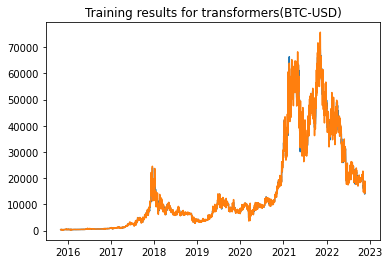

In [66]:
preds = clf.predict([x_train, y_train], y_scaler, data_scaled=False)
preds = pd.DataFrame(preds)

preds.reset_index(drop=True, inplace=True)
preds.index = df.index[-len(x_train):]
preds['Actual'] = y_train
preds.rename(columns={0: 'Predictions'}, inplace=True)


preds = inverse_stationary_data(old_df=df, new_df=preds,
                                      orig_feature='Actual', new_feature='Predictions',
                                      diff=12, do_orig=True)

predic = preds['Predictions']
act = preds['Actual']
plt.plot(predic)
plt.plot(act)
plt.title("Training results for transformers(BTC-USD)")
plt.show()

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Shape of train data: (x, y) = ((1769, 30, 16), (1769, 1))
Shape of test data: (x, y) = ((0,), (1, 1))
Loss for AAPLstock 6.886022838956867


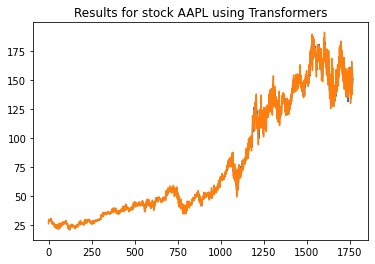

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Shape of train data: (x, y) = ((1769, 30, 16), (1769, 1))
Shape of test data: (x, y) = ((0,), (1, 1))
Loss for GOOGLstock 4.465642310164515


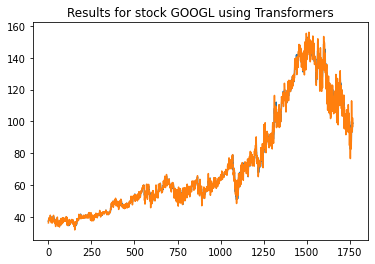

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


Shape of train data: (x, y) = ((1769, 30, 16), (1769, 1))
Shape of test data: (x, y) = ((0,), (1, 1))
Loss for TSLAstock 65.13349085458916


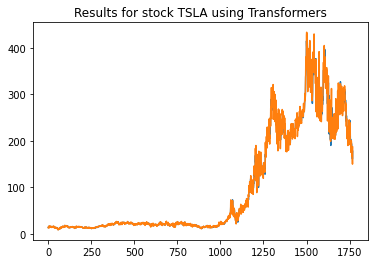

In [63]:
def plotTransformerResults(clf):
    for scrip in scrips:
        df = yf.download(scrip, start = start)
        dataset = GetDataset(df)
        dataset.get_dataset(scale=False)

        train_data, test_data, train_data_len = dataset.split(train_split_ratio=1, time_period=30)

        train_data, test_data = dataset.get_torchdata()
        x_train, y_train = train_data

        preds = clf.predict([x_train, y_train], y_scaler, data_scaled=False)
        preds = pd.DataFrame(preds)

        preds.reset_index(drop=True, inplace=True)
        preds.index = df.index[-len(x_train):]
        preds['Actual'] = y_train
        preds.rename(columns={0: 'Predictions'}, inplace=True)


        preds = inverse_stationary_data(old_df=df, new_df=preds,
                                            orig_feature='Actual', new_feature='Predictions',
                                            diff=12, do_orig=True)

        predic = preds['Predictions']
        act = preds['Actual']
        predic = pd.DataFrame(predic)
        act = pd.DataFrame(act)
        
        print("Loss for " + scrip + "stock", np.mean((np.array(predic["Predictions"]) - np.array(act["Actual"]))**2))
        plt.plot(np.array(predic["Predictions"]))
        plt.plot(np.array(act["Actual"]))
        plt.title(f"Results for stock {scrip} using Transformers")
        plt.show()

plotTransformerResults(clf)